In [29]:
print("Starting Brazil data")
import requests, zipfile, io

csse_path = "https://github.com/peixebabel/COVID-19/archive/master.zip"

r = requests.get(csse_path, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

Starting Brazil data


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os, math
from shutil import rmtree

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [30]:
root_path = os.path.join(os.getcwd(), "COVID-19-master/data/")
# save_path = os.path.join(os.getcwd(), "COVID-19-master/imagens/")
save_path = os.getcwd()
casos_br_path = os.path.join(os.getcwd(), root_path+"casos-br-total.csv")
df = pd.read_csv(casos_br_path)

In [31]:
df['Casos por dia'] = df['Confirmados'].diff()
df['Mortes por dia'] = df['Mortes'].diff()

# Casos acumulados

Starting Brazil cases and deaths


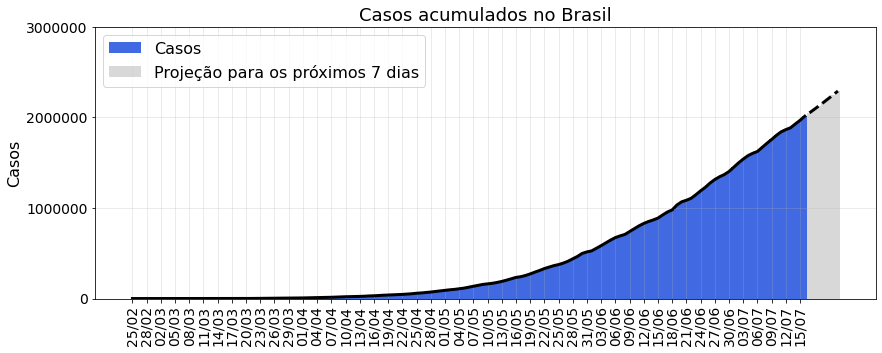

In [32]:
print("Starting Brazil cases and deaths")
def plot_proj(column, filename, title, dias_projecao, color):
  conf7 = list(df[column].to_numpy()[-7:])
  tc = [conf7[i+1]/conf7[i] for i in range(len(conf7)-1)]
  tc = np.array(tc).mean()
  for i in range(dias_projecao):
    conf7.append(conf7[-1]*tc)

  plt.figure(figsize=(14, 5))
  plt.bar(np.arange(len(df)), df[column].to_numpy(),width=1,label=filename.capitalize(), color=color)
  plt.plot(np.arange(len(df)), df[column].to_numpy(), color='k', linewidth=3, label=None)
  plt.plot(np.arange(len(df), len(df)+dias_projecao), conf7[-dias_projecao:], linestyle='dashed', linewidth=3, color='k', label=None)
  plt.bar(np.arange(len(df), len(df)+dias_projecao), conf7[-dias_projecao:],width=1,alpha=0.3, color='gray', 
          label='Projeção para os próximos '+str(dias_projecao)+ ' dias')
  plt.grid(True, alpha=0.3)
  plt.xticks(np.arange(len(df))[::3], df['Data'].to_numpy()[::3], rotation=90, fontsize=14)

  escala = min(6, len(str(int(conf7[-1])) )-1)
  ymax = (conf7[-1]//(10**escala) + 1) * (10**escala)
  num_values = int(ymax//(10**escala) + 1)

  ticks = [str(int(n)) for n in np.linspace(0,ymax,num_values) ]
  plt.yticks(np.linspace(0,ymax,num_values), ticks, fontsize=14)
  plt.ylabel(filename.capitalize(), fontsize=16)
  plt.legend(fontsize=16, loc=2)
  plt.title(title, fontsize=18)
  plt.savefig(os.path.join(save_path, filename+'.png'), format='png', dpi=150, bbox_inches='tight')

plot_proj('Confirmados', 'casos', 'Casos acumulados no Brasil', 7, 'royalblue')

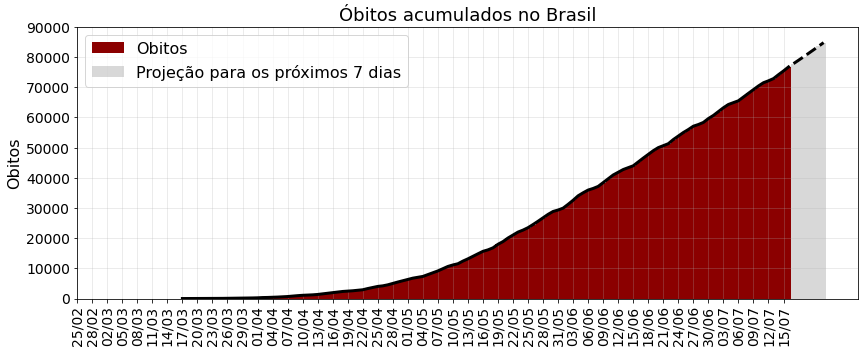

In [33]:
plot_proj('Mortes', 'obitos', 'Óbitos acumulados no Brasil', 7, 'darkred')

# Casos por dia

Starting Brazil cases and deaths per day


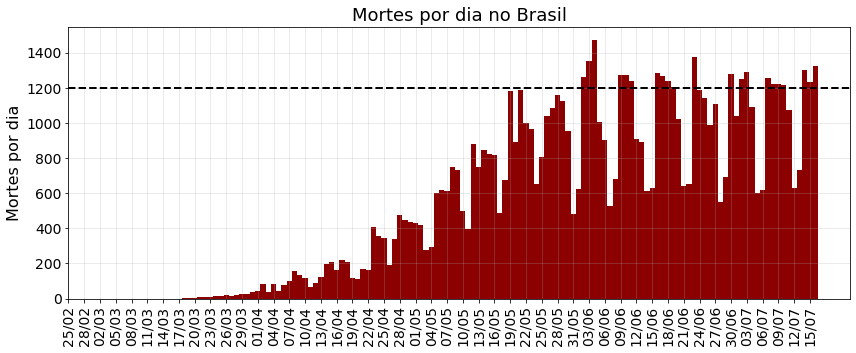

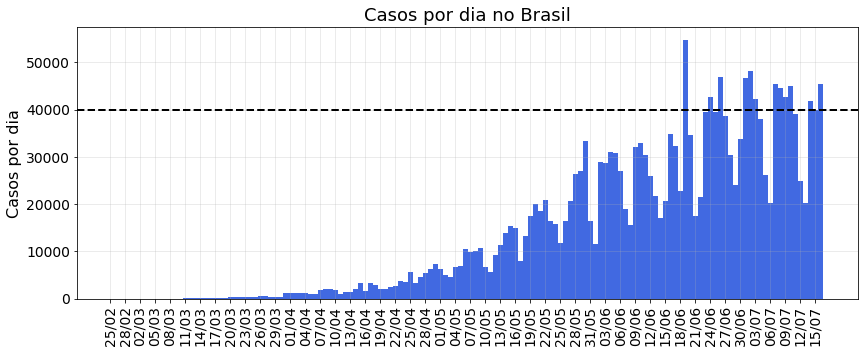

In [35]:
print("Starting Brazil cases and deaths per day")
from scipy.optimize import curve_fit

df['Casos por dia'] = df['Confirmados'].diff()
df['Mortes por dia'] = df['Mortes'].diff()

def plot_pordia(column, filename, color, hline):

  # polynomial fit #
  # values = df[column].to_numpy()
  # values = values[~np.isnan(values)]

  # x = np.linspace(0, 1, len(values))
  # fit = np.poly1d(np.polyfit(x, values, 2))
  # curve = fit(x)
  ###################

  # xmin = len(df)- len(values)
  # curve = np.hstack( ([np.nan] * xmin, curve ))
  # print(curve.shape)
  
  plt.figure(figsize=(14, 5))
  plt.bar(np.arange(len(df)), df[column].to_numpy(),width=1,label=column, color=color)
  # plt.plot(np.arange(len(curve)), curve, color='k', linewidth=3, label=None)
  plt.grid(True, alpha=0.3)
  plt.xticks(np.arange(len(df))[::3], df['Data'].to_numpy()[::3], rotation=90, fontsize=14)
  plt.yticks(fontsize=14)

  plt.axhline(hline, 0, len(df), linestyle='dashed', lw=2, color='k')

  plt.ylabel(column, fontsize=16)
  plt.title(column+' no Brasil', fontsize=18)

  plt.savefig(os.path.join(save_path, filename+'.png'), format='png', dpi=150, bbox_inches='tight')

plot_pordia('Mortes por dia', 'obitos-por-dia', 'darkred', 1200)
plot_pordia('Casos por dia', 'casos-por-dia', 'royalblue', 40000)

# Por Estado

In [8]:
print("Starting Brazil per state")
pop_estado = {
    'Rondônia': 1749000,
    'Acre': 790101,
    'Amazonas': 3874000,
    'Roraima': 496936,
    'Pará': 8074000,
    'Amapá': 751000,
    'Tocantins': 1497000,
    'Maranhão': 6851000,
    'Piauí': 3195000,
    'Ceará': 8843000,
    'Rio Grande do Norte': 3409000,
    'Paraíba': 3944000,
    'Pernambuco': 9278000,
    'Alagoas': 3322000,
    'Sergipe': 2220000,
    'Bahia': 15130000,
    'Minas Gerais': 20870000,
    'Espírito Santo': 3885000,
    'Rio de Janeiro': 16460000,
    'São Paulo': 44040000,
    'Paraná': 11080000,
    'Santa Catarina': 6727000,
    'Rio Grande do Sul': 11290000,
    'Mato Grosso do Sul': 2620000,
    'Mato Grosso': 3224000,
    'Goiás': 6523000,
    'Distrito Federal': 2570000,
}

Starting Brazil per state


In [9]:
ultimo_dia = sorted(os.listdir(root_path))[-2]
df = pd.read_csv(os.path.join(root_path, ultimo_dia))

def por_milhao(estados, numeros):

  # print(estados, numeros)
  for k, estado in enumerate(estados):
    e = estado.split('(')[0].rstrip()

    pop = pop_estado[e]/1000000
    numeros[k] = numeros[k]/pop 

  # print(numeros)
  return numeros

columns = df.iloc[2]
df.drop([0,1,2,30], inplace=True)
df.columns = columns

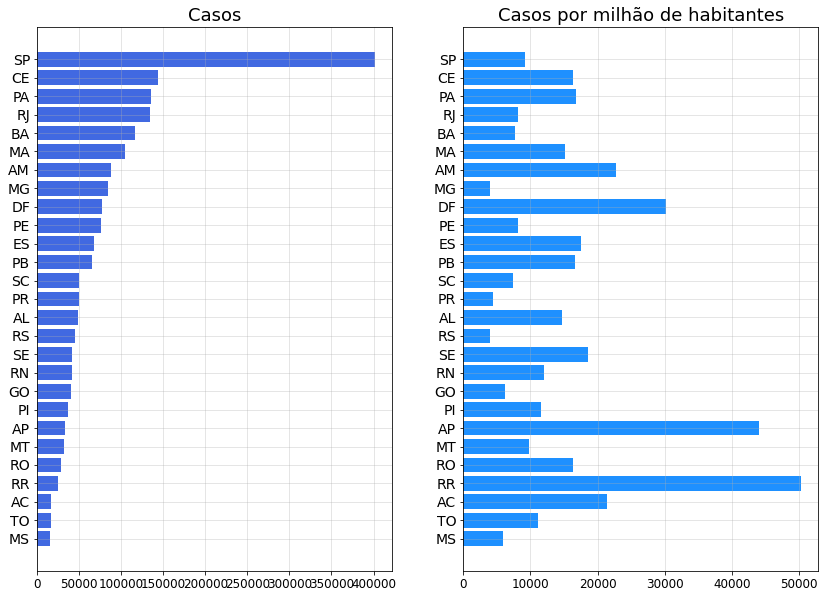

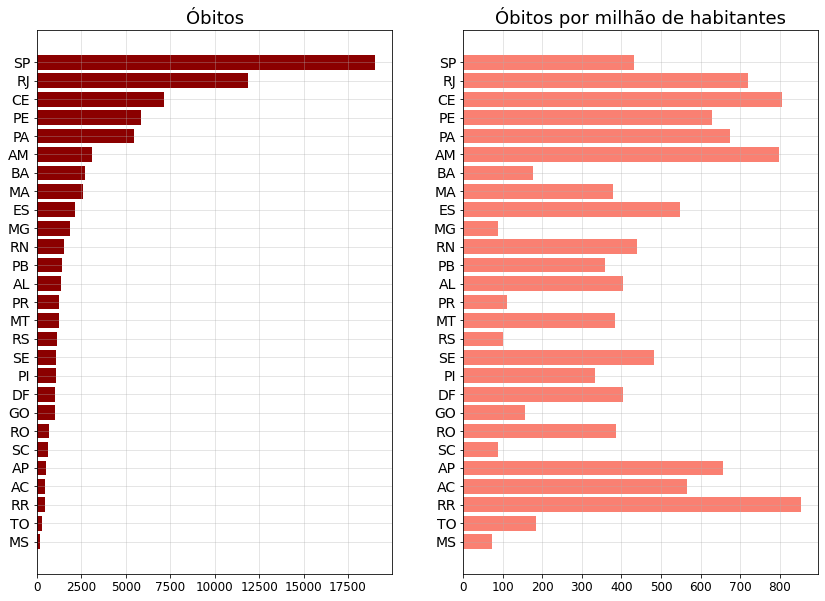

In [10]:
matplotlib.rcParams.update({'font.size': 12})
def plot_estado(df, column, filename, title, colors):
  df[column] = pd.to_numeric(df[column])
  df = df.sort_values(column, ascending=True)

  numeros = df[column].to_numpy(copy=True)
  pormilhao = por_milhao(df['Estado'], numeros)

  fig, axs = plt.subplots(1,2,figsize=(14, 10))
  axs[0].grid(True, alpha=0.4)
  axs[1].grid(True, alpha=0.4)
  axs[0].barh(width=df[column].to_numpy(), y=np.arange(len(pormilhao)), color=colors[0])
  axs[1].barh(width=pormilhao, y=np.arange(len(pormilhao)), color=colors[1])

  ticks = [st.split('(')[-1][:2] for st in df['Estado'].to_numpy()]

  axs[0].set_yticks(np.arange(len(pormilhao)) )
  axs[0].set_yticklabels(ticks, fontsize=14)
  axs[0].set_title(str(title), fontsize=18)

  axs[1].set_yticks(np.arange(len(pormilhao)) )
  axs[1].set_yticklabels(ticks, fontsize=14)
  axs[1].set_title(str(title) + ' por milhão de habitantes', fontsize=18)

  plt.savefig(os.path.join(save_path, filename+'.png'), format='png', dpi=150, bbox_inches='tight')

plot_estado(df, 'Secretarias', 'casos-por-estado', 'Casos', ['royalblue', 'dodgerblue'])
plot_estado(df, 'Óbitos', 'obitos-por-estado', 'Óbitos', ['darkred', 'salmon'])


In [11]:
rmtree("COVID-19-master")

# Crescimento Mundial

In [12]:
print("Starting world data")
import requests, zipfile, io

csse_path = "https://github.com/CSSEGISandData/COVID-19/archive/master.zip"

r = requests.get(csse_path, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

Starting world data


In [13]:
root_path = 'COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/'

recent = sorted(os.listdir(root_path))[-2]
path = os.path.join(root_path, recent)
df = pd.read_csv(path)
# print(df.shape)
# display(df)
name = [c for c in df.columns if "Country" in c]
countries = df[name[0]].to_numpy()
countries = np.unique(countries) 
# print(np.unique(countries))

In [14]:
ts = {'Deaths': {}, 'Confirmed': {}}
for country in np.unique(countries):
  ts['Deaths'][country] = []
  ts['Confirmed'][country] = []

for k, csv in enumerate(sorted(os.listdir(root_path))):
  print('\r{0}/{1}'.format(k, len(os.listdir(root_path))), end='', flush=True )
  if not csv[-3:] == 'csv': continue
    
  path = os.path.join(root_path, csv)
  df = pd.read_csv(path)

  for country in np.unique(countries):
    try:
      name = [c for c in df.columns if "Country" in c]
      ts['Deaths'][country].append(df[df[name[0]].str.contains(country)].sum()['Deaths'])
      ts['Confirmed'][country].append(df[df[name[0]].str.contains(country)].sum()['Confirmed'])
    except:
      ts['Deaths'][country].append(0)
      ts['Confirmed'][country].append(0)

2/179

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


178/179

In [15]:
df_deaths = pd.DataFrame.from_dict(ts['Deaths'])
df_deaths = df_deaths.sort_values(df_deaths.shape[0]-1, axis=1, ascending=False)
# display(df_deaths.iloc[-1])

df_confirmed = pd.DataFrame.from_dict(ts['Confirmed'])
df_confirmed = df_confirmed.sort_values(df_confirmed.shape[0]-1, axis=1, ascending=False)
# display(df_confirmed.iloc[-1])

## Casos e óbitos acumulados

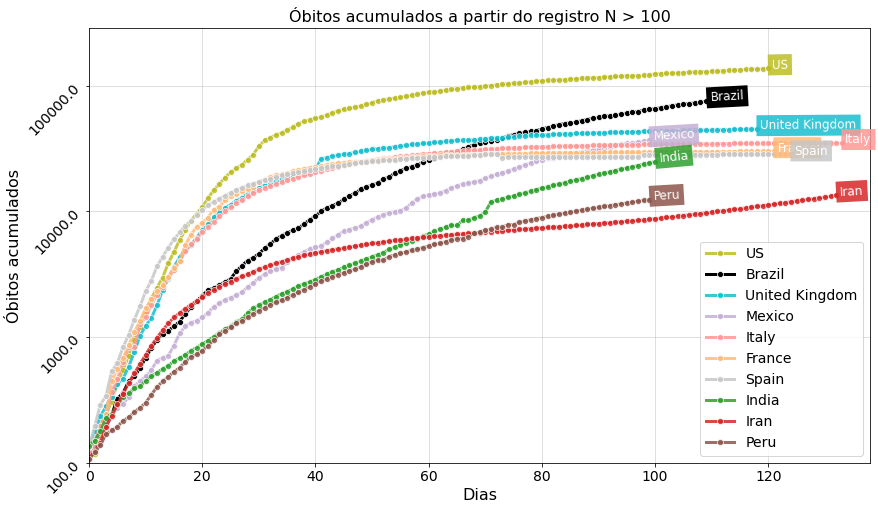

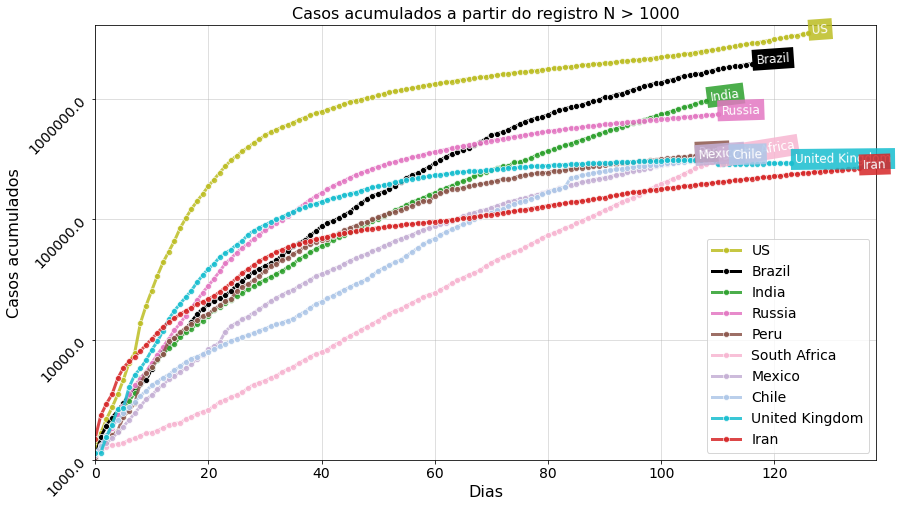

In [28]:
 def plot_log(info, title, filename, xlim, ylim, inicio, countries, colors): 
  
  plt.close('all')
  valores = {}
  plt.figure(figsize=(14, 8))
  styles = ['dashed', 'solid', 'dotted', 'solid', 'dashdot']
 
  n = -1
  for k, country in enumerate(countries):
    valores[country] = [t for t in ts[info][country] if t > inicio]
    if len(valores[country]) == 0: continue
    if country == 'China': n = xlim
    else: n = -1
    y = len(valores[country][:n]) +0.1
    altura = np.log10(valores[country][:n])[-1]
    alpha = 0.85
    if country == 'Germany': altura -= 0.05
    if country == 'Brazil': 
      # altura += 0.05
      y += 0.1
      alpha = 1
      colors[country] = [0, 0, 0, 1]
    p = sns.lineplot(np.arange(len(valores[country][:n])), np.log10(valores[country][:n]), label=country, linewidth=3, color=colors[country], alpha=alpha, marker='o', linestyle='solid')
    color = p.get_lines()[-1].get_color()

    dy = np.log10(valores[country][-1]) - np.log10(valores[country][-7]) 
    rot = max(0, math.atan2(dy,7))  * (180/math.pi) * 10
    t = plt.text(y-0.5, altura, country , fontsize=12, rotation=rot,color='w',alpha=1.,
                bbox=dict(facecolor=color, edgecolor='none', alpha=alpha))

  
  plt.xticks(fontsize=14)
  ticks = [str(10**i) for i in np.arange(0, ylim+1)]
  plt.yticks(np.arange(0, ylim+1), ticks, fontsize=14, rotation=46)
  plt.xlabel('Dias', fontsize=16)
  plt.ylabel(title + ' acumulados', fontsize=16)
  
  plt.title(title + ' acumulados a partir do registro N > ' + str(inicio), fontsize=16)
  plt.grid(True, alpha=0.5)
  
  plt.xlim(0, xlim)
  ylim_lower = max(0, np.floor(np.log10(inicio)) )
  plt.ylim(ylim_lower,ylim*1.05)
  plt.legend(fontsize=14, loc=4)
  plt.show()  
  # plt.savefig(filename+'.png', format='png', dpi=150, bbox_inches='tight')

num_countries = 10

countries_deaths = df_deaths.columns.tolist()[:num_countries]
countries_confirmed = df_confirmed.columns.tolist()[:num_countries]

all_countries = np.unique(np.concatenate((countries_deaths,countries_confirmed),0))
colors = pl.cm.tab20(np.linspace(0,1,len(all_countries)+1))
# np.random.shuffle(colors)

color_dict = {}
for k, country in enumerate(all_countries):
  color_dict[country] = colors[k]


plot_log('Deaths', 'Óbitos', 'obitos-mundo', 138, 5.2, 100, countries_deaths, color_dict)
plot_log('Confirmed', 'Casos', 'casos-mundo', 138, 6.3, 1000, countries_confirmed, color_dict)

## Casos e óbitos por dia

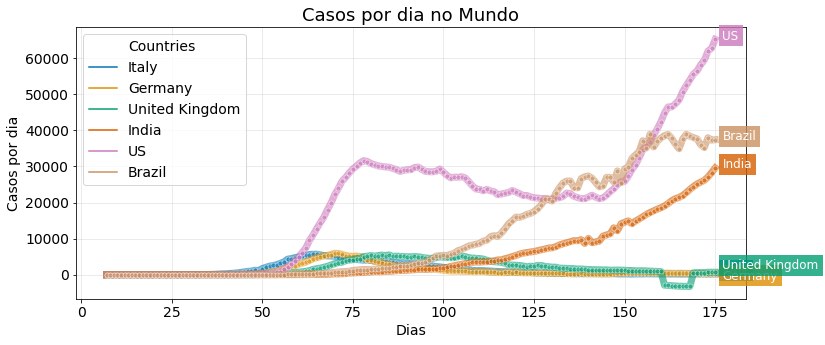

In [17]:
countries_confirmed = ['Italy','Germany', 'United Kingdom','India','US', 'Brazil']
df_ = pd.DataFrame(columns=countries_confirmed)
for k, country in enumerate(countries_confirmed):

  conf = df_confirmed[country]
  conf = [conf[k+1] - conf[k] for k in range(len(conf)-1)]

  df_[country] = conf
  df_[country] = df_[country].rolling(8).mean()

df_['Indice'] = np.arange(len(df_))
dfm = df_.melt('Indice', var_name='Countries', value_name='Cases')
dfm.head()

fig, ax = plt.subplots(figsize=(12, 5))
plt.grid(True, alpha=0.3)
sns.lineplot(data=dfm, x='Indice', y='Cases', hue='Countries', lw=7, alpha=0.6, marker='o', markersize=5, palette='colorblind')

lines = [r for r in ax.get_children() if type(r) == Line2D ]
colors = [c.get_color() for c in lines[:-1]]

for k, country in enumerate(dfm['Countries'].unique()):
  subtract = 0
  if country in ['Germany']: subtract = 1600
  elif country in ['United Kingdom']: subtract = -1000 
  t = plt.text(len(df_)+1, df_[country].to_numpy()[-1]-subtract, country , fontsize=12, rotation=0,color='w',alpha=1.,
                    bbox=dict(facecolor=colors[k], edgecolor='none', alpha=0.8))

plt.legend(fontsize=14)
plt.ylabel('Casos por dia', fontsize=14)
plt.xlabel('Dias', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Casos por dia no Mundo', fontsize=18)
plt.savefig('casos-por-dia-mundo.png', dpi=150, format='png', bbox_inches='tight')

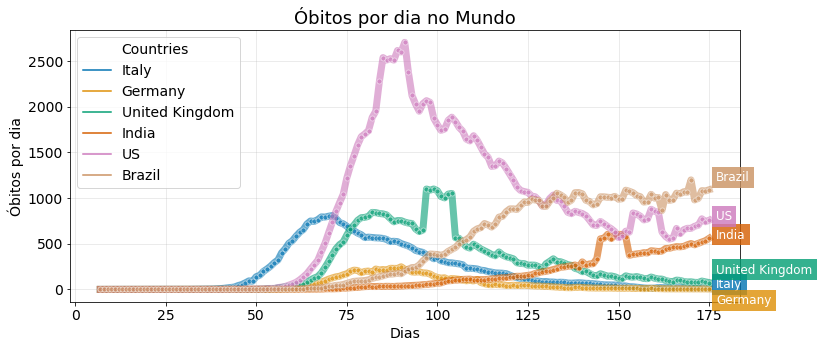

In [18]:
countries_confirmed = ['Italy','Germany', 'United Kingdom','India','US', 'Brazil']
df_ = pd.DataFrame(columns=countries_confirmed)
for k, country in enumerate(countries_confirmed):

  conf = df_deaths[country]
  conf = [conf[k+1] - conf[k] for k in range(len(conf)-1)]

  df_[country] = conf
  df_[country] = df_[country].rolling(8).mean()

df_['Indice'] = np.arange(len(df_))
dfm = df_.melt('Indice', var_name='Countries', value_name='Cases')
dfm.head()

fig, ax = plt.subplots(figsize=(12, 5))
plt.grid(True, alpha=0.3)
sns.lineplot(data=dfm, x='Indice', y='Cases', hue='Countries', lw=7, alpha=0.6, marker='o', markersize=5, palette='colorblind')

lines = [r for r in ax.get_children() if type(r) == Line2D ]
colors = [c.get_color() for c in lines[:-1]]

for k, country in enumerate(dfm['Countries'].unique()):
  subtract = 0
  if country in ['Germany']: subtract = 160
  elif country in ['United Kingdom']: subtract = -100 
  elif country in ['Brazil']: subtract = -100 
  t = plt.text(len(df_)+1, df_[country].to_numpy()[-1]-subtract, country , fontsize=12, rotation=0,color='w',alpha=1.,
                    bbox=dict(facecolor=colors[k], edgecolor='none', alpha=0.8))

plt.legend(fontsize=14)
plt.ylabel('Óbitos por dia', fontsize=14)
plt.xlabel('Dias', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Óbitos por dia no Mundo', fontsize=18)
plt.savefig('obitos-por-dia-mundo.png', dpi=150, format='png', bbox_inches='tight')

In [19]:
rmtree("COVID-19-master")

In [20]:
!zip includes.zip *.png

  adding: casos-mundo.png (deflated 5%)
  adding: casos.png (deflated 13%)
  adding: casos-por-dia-mundo.png (deflated 4%)
  adding: casos-por-dia.png (deflated 15%)
  adding: casos-por-estado.png (deflated 22%)
  adding: obitos-mundo.png (deflated 5%)
  adding: obitos.png (deflated 11%)
  adding: obitos-por-dia-mundo.png (deflated 4%)
  adding: obitos-por-dia.png (deflated 14%)
  adding: obitos-por-estado.png (deflated 21%)
